Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [15]:
!pip install -q IPython
!pip install -q ipykernel
!pip install -q watermark
!pip install -q matplotlib
!pip install -q sklearn
!pip install -q pandas
!pip install -q pydot
!pip install -q hiddenlayer
!pip install -q graphviz
!pip install -q tensorwatch

     |████████████████████████████████| 194kB 2.6MB/s 
     |████████████████████████████████| 143kB 8.1MB/s 


In [2]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.6.9
IPython 5.5.0

torch 1.5.1+cu101


- Runs on CPU or GPU (if available)

# Basic Graph Neural Network with Spectral Graph Convolution on MNIST

Implementing a very basic graph neural network (GNN) using a spectral graph convolution. 

Here, the 28x28 image of a digit in MNIST represents the graph, where each pixel (i.e., cell in the grid) represents a particular node. The feature of that node is simply the pixel intensity in range [0, 1]. 

Here, the adjacency matrix of the pixels is basically just determined by their neighborhood pixels. Using a Gaussian filter, we connect pixels based on their Euclidean distance in the grid.

In the related notebook, [./gnn-basic-1.ipynb](./gnn-basic-1.ipynb), we used this adjacency matrix $A$ to compute the output of a layer as 

$$X^{(l+1)}=A X^{(l)} W^{(l)}.$$

Here, $A$ is the $N \times N$ adjacency matrix, and $X$ is the $N \times C$ feature matrix (a  2D coordinate array, where $N$ is the total number of pixels -- $28 \times 28 = 784$ in MNIST). $W$ is the weight matrix of shape $N \times P$, where $P$ would represent the number of classes if we have only a single hidden layer.

In this notebook, we modify this code using spectral graph convolution, i.e.,

$$X^{(l+1)}=V\left(V^{T} X^{(l)} \odot V^{T} W_{\text {spectral }}^{(l)}\right).$$

Where $V$ are the eigenvectors of the graph Laplacian $L$, which we can compute from the adjacency matrix $A$. Here, $W_{\text {spectral }}$ represents the trainable weights (filters).

- Inspired by and based on Boris Knyazev's tutorial at https://towardsdatascience.com/tutorial-on-graph-neural-networks-for-computer-vision-and-beyond-part-2-be6d71d70f49.

## Imports

In [3]:
import time
import numpy as np
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

## Settings and Dataset

In [5]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.05
NUM_EPOCHS = 50
BATCH_SIZE = 128
IMG_SIZE = 28

# Architecture
NUM_CLASSES = 10

## MNIST Dataset

In [6]:
train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)

custom_transform = transforms.Compose([transforms.ToTensor()])


train_and_valid = datasets.MNIST(root='data', 
                                 train=True, 
                                 transform=custom_transform,
                                 download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=custom_transform,
                              download=True)

train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!




/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## Model

In [7]:
def precompute_adjacency_matrix(img_size):
    col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
    
    # N = img_size^2
    # construct 2D coordinate array (shape N x 2) and normalize
    # in range [0, 1]
    coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size

    # compute pairwise distance matrix (N x N)
    dist = cdist(coord, coord, metric='euclidean')
    
    # Apply Gaussian filter
    sigma = 0.05 * np.pi
    A = np.exp(- dist / sigma ** 2)
    A[A < 0.01] = 0
    A = torch.from_numpy(A).float()
    
    return A

    """
    # Normalization as per (Kipf & Welling, ICLR 2017)
    D = A.sum(1)  # nodes degree (N,)
    D_hat = (D + 1e-5) ** (-0.5)
    A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N
    
    return A_hat
    """


def get_graph_laplacian(A):
    # From https://towardsdatascience.com/spectral-graph-convolution-
    #   explained-and-implemented-step-by-step-2e495b57f801
    #
    # Computing the graph Laplacian
    # A is an adjacency matrix of some graph G
    N = A.shape[0] # number of nodes in a graph
    D = np.sum(A, 0) # node degrees
    D_hat = np.diag((D + 1e-5)**(-0.5)) # normalized node degrees
    L = np.identity(N) - np.dot(D_hat, A).dot(D_hat) # Laplacian
    return torch.from_numpy(L).float()

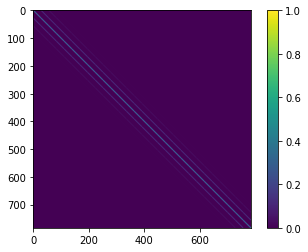

In [8]:
A = precompute_adjacency_matrix(28)
plt.imshow(A, vmin=0., vmax=1.)
plt.colorbar()
plt.show()

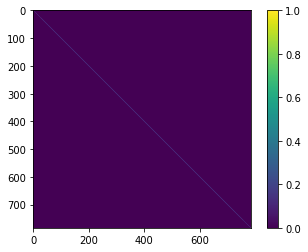

In [9]:
L = get_graph_laplacian(A.numpy())
plt.imshow(L, vmin=0., vmax=1.)
plt.colorbar()
plt.show()

In [10]:
##########################
### MODEL
##########################

from scipy.sparse.linalg import eigsh
        

class GraphNet(nn.Module):
    def __init__(self, img_size=28, num_filters=2, num_classes=10):
        super(GraphNet, self).__init__()
        
        n_rows = img_size**2
        self.fc = nn.Linear(n_rows*num_filters, num_classes, bias=False)

        A = precompute_adjacency_matrix(img_size)
        L = get_graph_laplacian(A.numpy())
        Λ,V = eigsh(L.numpy(), k=20, which='SM') # eigen-decomposition (i.e. find Λ,V)

        V = torch.from_numpy(V)
        
        # Weight matrix
        W_spectral = nn.Parameter(torch.ones((img_size**2, num_filters))).float()
        torch.nn.init.kaiming_uniform_(W_spectral)
        
        self.register_buffer('A', A)
        self.register_buffer('L', L)
        self.register_buffer('V', V)
        self.register_buffer('W_spectral', W_spectral)

        

    def forward(self, x):
        
        B = x.size(0) # Batch size

        ### Reshape eigenvectors
        # from [H*W, 20] to [B, H*W, 20]
        V_tensor = self.V.unsqueeze(0)
        V_tensor = self.V.expand(B, -1, -1)
        # from [H*W, 20] to [B, 20, H*W]
        V_tensor_T = self.V.T.unsqueeze(0)
        V_tensor_T = self.V.T.expand(B, -1, -1)
        
        ### Reshape inputs
        # [B, C, H, W] => [B, H*W, 1]
        x_reshape = x.view(B, -1, 1)
        
        ### Reshape spectral weights
        # to size [128, H*W, F]
        W_spectral_tensor = self.W_spectral.unsqueeze(0)
        W_spectral_tensor = self.W_spectral.expand(B, -1, -1)
        
        ### Spectral convolution on graphs
        # [B, 20, H*W] . [B, H*W, 1]  ==> [B, 20, 1]
        X_hat = V_tensor_T.bmm(x_reshape) # 20×1 node features in the "spectral" domain
        W_hat = V_tensor_T.bmm(W_spectral_tensor)  # 20×F filters in the "spectral" domain
        Y = V_tensor.bmm(X_hat * W_hat)  # N×F result of convolution

        ### Fully connected
        logits = self.fc(Y.reshape(B, -1))
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [11]:
torch.manual_seed(RANDOM_SEED)
model = GraphNet(img_size=IMG_SIZE, num_classes=NUM_CLASSES)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)  

In [13]:
import hiddenlayer as hl
hl.build_graph(model, torch.zeros([128, 1, 28, 28]).to(DEVICE))

/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:738: UserWarning: ONNX export failed on ATen operator numpy_T because torch.onnx.symbolic_opset9.numpy_T does not exist
  .format(op_name, opset_version, op_name))


RuntimeError: ignored

In [16]:
import tensorwatch as tw
tw.draw_model(model, [128, 1, 28, 28])

RuntimeError: ignored

## Training

In [ ]:
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader, device=DEVICE)
        valid_acc = compute_acc(model, valid_loader, device=DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')
        
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/050 | Batch 000/461 | Cost: 2.3048
Epoch: 001/050 | Batch 150/461 | Cost: 1.2503
Epoch: 001/050 | Batch 300/461 | Cost: 0.9677
Epoch: 001/050 | Batch 450/461 | Cost: 0.9317
Epoch: 001/050
Train ACC: 75.17 | Validation ACC: 79.60
Time elapsed: 0.22 min
Epoch: 002/050 | Batch 000/461 | Cost: 0.9826
Epoch: 002/050 | Batch 150/461 | Cost: 0.7964
Epoch: 002/050 | Batch 300/461 | Cost: 0.8447
Epoch: 002/050 | Batch 450/461 | Cost: 0.9356
Epoch: 002/050
Train ACC: 77.79 | Validation ACC: 82.50
Time elapsed: 0.43 min
Epoch: 003/050 | Batch 000/461 | Cost: 0.8216
Epoch: 003/050 | Batch 150/461 | Cost: 0.7701
Epoch: 003/050 | Batch 300/461 | Cost: 0.7437
Epoch: 003/050 | Batch 450/461 | Cost: 0.7210
Epoch: 003/050
Train ACC: 78.63 | Validation ACC: 83.00
Time elapsed: 0.64 min
Epoch: 004/050 | Batch 000/461 | Cost: 0.7137
Epoch: 004/050 | Batch 150/461 | Cost: 0.7224
Epoch: 004/050 | Batch 300/461 | Cost: 0.7001
Epoch: 004/050 | Batch 450/461 | Cost: 0.7026
Epoch: 004/050
Train ACC: 7

## Evaluation

In [ ]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
with torch.set_grad_enabled(False):
    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)
    
    valid_acc = compute_acc(model=model,
                            data_loader=valid_loader,
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

In [ ]:
%watermark -iv